Execute the following commands in the terminal

In [ ]:
conda install mamba -n base -c conda-forge
mamba create -n dl_appendicitis python=3.10 pandas tensorflow seaborn scikit-learn openpyxl xlrd
conda activate dl_appendicitis
pip install simpletransformers
pip install ucimlrepo
pip install torch torchvision torchaudio
pip install python-dotenv
pip install tensorflow_datasets

## Import and glimpse at the data

### Load the non-image data from the regensburg pediatric appendicitis data set

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938) 

# metadata 
print(regensburg_pediatric_appendicitis.metadata) 
  
# variable information 
print(regensburg_pediatric_appendicitis.variables) 


{'uci_id': 938, 'name': 'Regensburg Pediatric Appendicitis', 'repository_url': 'https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis', 'data_url': 'https://archive.ics.uci.edu/static/public/938/data.csv', 'abstract': 'This repository holds the data from a cohort of pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021. Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Image'], 'num_instances': 782, 'num_features': 53, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Sex'], 'target_col': ['Management', 'Severity',

Store the features and targets from the data set

In [2]:
# data (as pandas dataframes) 
import pandas as pd
rpa_features = pd.DataFrame(regensburg_pediatric_appendicitis.data.features)
rpa_targets = regensburg_pediatric_appendicitis.data.targets 

#### Display some of the loaded data

In [3]:
rpa_features.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,12.68,16.9,female,148.0,37.0,3.0,4.0,3.0,yes,7.1,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.10,31.9,male,147.0,69.5,2.0,5.0,4.0,no,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN
2,14.14,23.3,female,163.0,62.0,4.0,5.0,3.0,no,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,NaN
3,16.37,20.6,female,165.0,56.0,3.0,7.0,6.0,no,NaN,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN
4,11.08,16.9,female,163.0,45.0,3.0,5.0,6.0,yes,7.0,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN


In [4]:
rpa_targets.head()

,Management,Severity,Diagnosis
0,conservative,uncomplicated,appendicitis
1,conservative,uncomplicated,no appendicitis
2,conservative,uncomplicated,no appendicitis
3,conservative,uncomplicated,no appendicitis
4,conservative,uncomplicated,appendicitis


## Process the clinical data (DNN)

### Data cleaning

Remove rows with NAs in target data frame

In [5]:
rpa_targets_cleaned = rpa_targets.loc[rpa_targets.notna().all(axis=1)]

Combine the targets to keep only information about diagnosis and severity in one column

In [6]:
def check_dx(row): 
    if row['Diagnosis'] == 'no appendicitis':
        return 'no appendicitis'
    return row['Severity']
    
rpa_targets_cleaned['Dx_inclSeverity'] = rpa_targets_cleaned.apply(check_dx, axis=1)
# axis=1 means apply function per row

/var/folders/3b/qp59k9pj1_dcb075s8_dvpc00000gp/T/ipykernel_55740/1956955833.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rpa_targets_cleaned['Dx_inclSeverity'] = rpa_targets_cleaned.apply(check_dx, axis=1)


Check for missing values

In [7]:
# from https://medium.com/bitgrit-data-science-publication/data-cleaning-with-python-f6bc3da64e45:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(rpa_features)

Age => 1
BMI => 27
Sex => 2
Height => 26
Weight => 3
Length_of_Stay => 4
Alvarado_Score => 52
Paedriatic_Appendicitis_Score => 52
Appendix_on_US => 5
Appendix_Diameter => 284
Migratory_Pain => 9
Lower_Right_Abd_Pain => 8
Contralateral_Rebound_Tenderness => 15
Coughing_Pain => 16
Nausea => 8
Loss_of_Appetite => 10
Body_Temperature => 7
WBC_Count => 6
Neutrophil_Percentage => 103
Segmented_Neutrophils => 728
Neutrophilia => 50
RBC_Count => 18
Hemoglobin => 18
RDW => 26
Thrombocyte_Count => 18
Ketones_in_Urine => 200
RBC_in_Urine => 206
WBC_in_Urine => 199
CRP => 11
Dysuria => 29
Stool => 17
Peritonitis => 9
Psoas_Sign => 37
Ipsilateral_Rebound_Tenderness => 163
US_Performed => 4
Free_Fluids => 63
Appendix_Wall_Layers => 564
Target_Sign => 644
Appendicolith => 713
Perfusion => 719
Perforation => 701
Surrounding_Tissue_Reaction => 530
Appendicular_Abscess => 697
Abscess_Location => 769
Pathological_Lymph_Nodes => 579
Lymph_Nodes_Location => 661
Bowel_Wall_Thickening => 683
Conglomerate_of_

In [8]:
# join features and targets for data cleaning
rpa_combined = rpa_features.join(rpa_targets_cleaned)
# copy the data frame to restore mistakes
# (if not copied the the new variable references the SAME data frame)
rpa_combined_cleaning = rpa_combined.copy()



Renaming values

In [10]:
import numpy as np
# convert 'NaN' strings to actual nan
rpa_combined_cleaning.replace('NaN', np.nan, inplace=True)

#### Outliers

Visualize outliers with box-plots

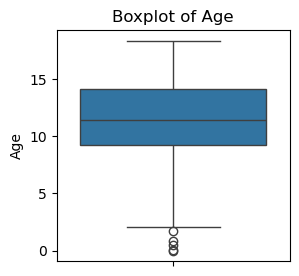

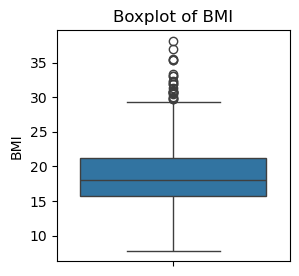

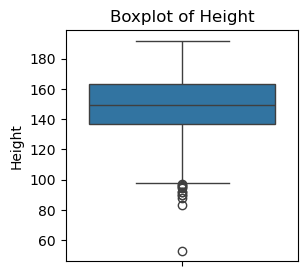

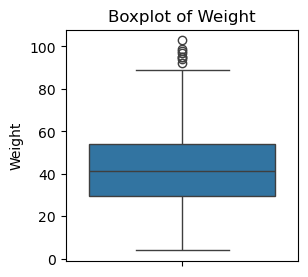

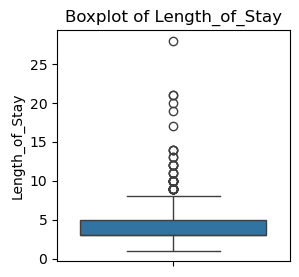

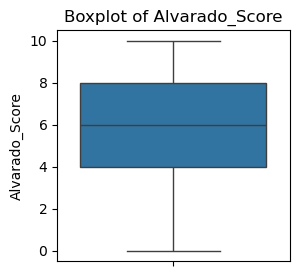

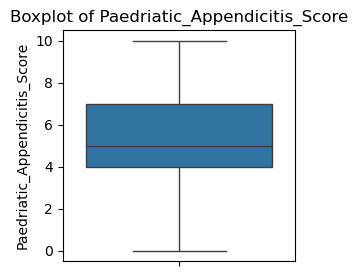

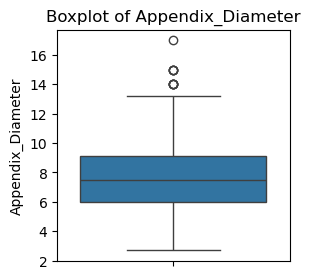

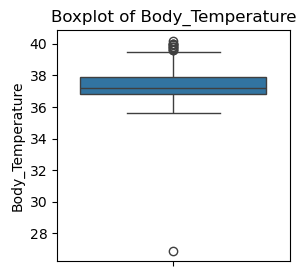

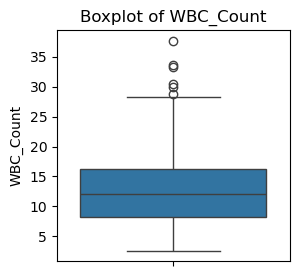

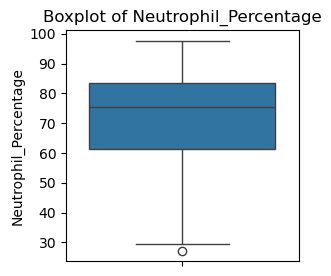

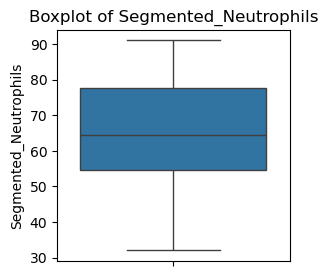

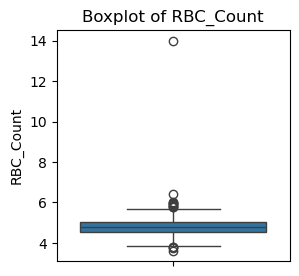

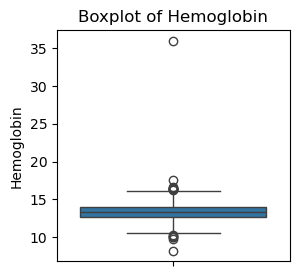

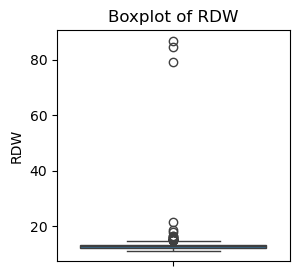

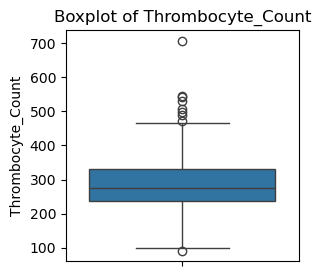

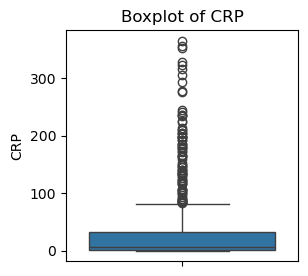

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns 
# select only numeric columns
numeric_columns = rpa_combined_cleaning.select_dtypes(include='number').columns
# create a boxplot for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(3, 3))
    sns.boxplot(y=rpa_combined_cleaning[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

Delete certain outliers

In [16]:
rpa_combined_cleaning = rpa_combined_cleaning.drop([221]) # body_temperature 26.9 celsius degree not viable
rpa_combined_cleaning = rpa_combined_cleaning.drop([203]) # RBC_Count 14 G/L massive outlier
rpa_combined_cleaning = rpa_combined_cleaning.drop([564]) # hemoglobin 34 g/L not plausible

#### NAs

Set NAs to zero

In [17]:
# set appendix_diameter entries to zero if Appendix_on_US is 'no' (almost all NA)
rpa_combined_cleaning.loc[rpa_combined_cleaning['Appendix_on_US'] == 'no', 'Appendix_Diameter'] = 0

# reconsider this while evaluating the model
""" not suitable for neural network since data in collumn becomes strings: 
# rename the appendix_diameter entries to 'not_found_on_us' if Appendix_on_US is 'no' (almost all NA) 
rpa_combined_cleaning.loc[rpa_combined_cleaning['Appendix_on_US'] == 'no', 'Appendix_Diameter'] = 'not_found_on_us'
"""

" not suitable for neural network since data in collumn becomes strings: \n# rename the appendix_diameter entries to 'not_found_on_us' if Appendix_on_US is 'no' (almost all NA) \nrpa_combined_cleaning.loc[rpa_combined_cleaning['Appendix_on_US'] == 'no', 'Appendix_Diameter'] = 'not_found_on_us'\n"

Calculate missing values

In [18]:
# calculate missing BMI in one row
rpa_combined_cleaning.loc[550, 'BMI'] = rpa_combined_cleaning.loc[550, 'Weight'] / ((rpa_combined_cleaning.loc[550, 'Height']/100) * (rpa_combined_cleaning.loc[550, 'Height']/100))

Convert NAs in clinical group to "unknown"

In [23]:
import pandas as pd
# define variable group (as defined by the data originaters)
clinical_group = ['Peritonitis', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'Ipsilateral_Rebound_Tenderness', 'Coughing_Pain', 'Psoas_Sign', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'Dysuria', 'Stool']
# remove numeric collumns from group
clinical_group_mod = pd.Series(clinical_group)
clinical_group_mod = clinical_group_mod[clinical_group_mod != 'Body_Temperature'].tolist() 
# create dictionary to map each prefixed column name to the replacement value 'unknown'
fill_clin_na_dict = {col: 'unknown' for col in clinical_group_mod}
# replace NAs in findings with 'Unknown'
rpa_combined_cleaning.fillna(fill_clin_na_dict, inplace=True)

Convert NAs in ultrasound group to "no_us_finding"

In [25]:
# define variable group (as defined by the data originaters)
ultrasound_group = ['US_Performed', 'Appendix_on_US', 'Appendix_Diameter', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign', 'Perfusion', 'Surrounding_Tissue_Reaction', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location', 'Bowel_Wall_Thickening', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis', 'Appendicolith', 'Perforation', 'Appendicular_Abscess', 'Abscess_Location', 'Conglomerate_of_Bowel_Loops', 'Gynecological_Findings']
# select non-numeric columns
non_numeric_columns = rpa_combined_cleaning.select_dtypes(exclude='number').columns
# create dictionary to map non-numeric column to 'no_us_finding'
fill_us_na_dict = {col: 'no_us_finding' for col in non_numeric_columns if col in ultrasound_group}
# replace NAs in the non-numeric columns with 'no_us_finding'
rpa_combined_cleaning.fillna(fill_us_na_dict, inplace=True)

Remove rows

In [26]:
# remove rows with few missing NAs (use loc!!)
# cols = ['Age', 'Sex', 'Length_of_Stay', 'US_Performed', 'Body_Temperature', 'Height', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'WBC_Count', 'RBC_Count', 'Hemoglobin', 'Thrombocyte_Count', 'CRP']
cols = ['Age', 'Sex', 'Length_of_Stay', 'US_Performed', 'Body_Temperature', 'Height', 'Appendix_Diameter', 'WBC_Count', 'RBC_Count', 'Hemoglobin', 'Thrombocyte_Count', 'CRP']
for col in cols:
    rpa_combined_cleaning = rpa_combined_cleaning.loc[rpa_combined_cleaning[col].notna()] # use .loc to access the row!!

Drop collumns with too many NAs

In [27]:
#  Alvarado_Score & Paedriatic_Appendicitis_Score: 6% missing (45); Neutrophil_Percentage: 13% missing (96); Segmented_Neutrophils 93% missing; Neutrophilia 6% missing; RDW 3% missing and prob no relevant; Ketones_in_Urine, RBC_in_Urine & WBC_in_Urine 25% missing; Dysuria 3% missing and 91% no; Psoas_Sign 4% missing; Ipsilateral_Rebound_Tenderness 20% missing; Free_Fluids 7% missing; 
rpa_combined_cleaning = rpa_combined_cleaning.drop(columns=['Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia', 'RDW', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine'])

#### Faulty data

In [28]:
# select rows via labeled index like rpa_combined_cleaning.loc[[656, 638, 405]])
# drop these rows directly via drop method
rpa_combined_cleaning = rpa_combined_cleaning.drop([656, 638]) # cases with height > 140 cm, but age < 1 -> faulty data

#### Post-Cleaning

Check that there are no missing values left

In [29]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(rpa_combined_cleaning)

no missing values left


Separate features & labels again

In [30]:
# after cleaning, separate features and targets again
rpa_combined_cleaned = rpa_combined_cleaning.copy()
rpa_targets_cleaned = rpa_combined_cleaned[["Management", "Severity", "Diagnosis", "Dx_inclSeverity"]]
rpa_features_cleaned = rpa_combined_cleaned.drop(columns=["Management", "Severity", "Diagnosis", "Dx_inclSeverity"])

### Training preparation

Transform data

In [31]:
rpa_targets_transforming = rpa_targets_cleaned.copy()
rpa_features_transforming = rpa_features_cleaned.copy()

One-hot encode the target labels (v1 with all targets)

In [32]:
# one-hot encode each column
rpa_targets_transformed = pd.get_dummies(rpa_targets_transforming)

One-hot encode the target labels (v2 with reduced targets)

In [33]:
# one-hot encode
rpa_targets_transformed = pd.get_dummies(rpa_targets_transforming["Dx_inclSeverity"])

One-hot encode the features

In [34]:
# select categorical columns
categorical_columns = rpa_features_transforming.select_dtypes(include='object').columns

# one-hot encode categorical columns
rpa_features_transforming = pd.get_dummies(rpa_features_transforming, columns=categorical_columns)

Scale numeric data between 0 and 1

In [35]:
# scale numerical data for the neural network to function correctly
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
 
# select numeric columns
numeric_columns = rpa_features_transforming.select_dtypes(include='number').columns

# scale the numeric columns
rpa_features_transforming[numeric_columns] = scaler.fit_transform(rpa_features_transforming[numeric_columns])

In [36]:
rpa_features_transformed = rpa_features_transforming.copy()

In [37]:
# x_train and y_train should be numpy arrays
rpa_features_transformed = np.array(rpa_features_transformed).astype('float32')
rpa_targets_transformed = np.array(rpa_targets_transformed).astype('float32')
"""
# Check shapes
print(f"x_train shape: {rpa_features_transformed.shape}")
print(f"y_train shape: {rpa_targets_transformed.shape}")
"""

'\n# Check shapes\nprint(f"x_train shape: {rpa_features_transformed.shape}")\nprint(f"y_train shape: {rpa_targets_transformed.shape}")\n'

Split into train & test data

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(rpa_features_transformed, rpa_targets_transformed, test_size = 0.2)

### Create the model

In [39]:
from simpletransformers.classification import ClassificationArgs
model_args = ClassificationArgs()
model_args.num_train_epochs = 5
model_args.learning_rate = 1e-4

2024-06-20 11:06:23.910488: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/fabianburki/miniconda3/envs/dl_appendicitis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DNN with batch norm

In [52]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=512, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=y_train.shape[1], activation='softmax')  # classification layer with number of classes in y_train (no, app, compl app)
])
model.summary()

/Users/fabianburki/miniconda3/envs/dl_appendicitis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,971 (953.01 KB)

 Trainable params: 242,179 (946.01 KB)

 Non-trainable params: 1,792 (7.00 KB)

Compile model

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

Train model & plot results

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 7.7533e-04 - val_accuracy: 0.7478 - val_loss: 1.4265
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9964 - loss: 0.0084 - val_accuracy: 0.7913 - val_loss: 1.4881
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9986 - loss: 0.0081 - val_accuracy: 0.8000 - val_loss: 1.5064
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.7913 - val_loss: 1.3475
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.7913 - val_loss: 1.3018
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.7652 - val_loss: 1.3843
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9941 - loss: 0.0177 - val_accuracy: 0.7826 - val_loss: 1.4395
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9949 - loss: 0.0080 - val_accuracy: 0.7478 - val_loss: 1.4

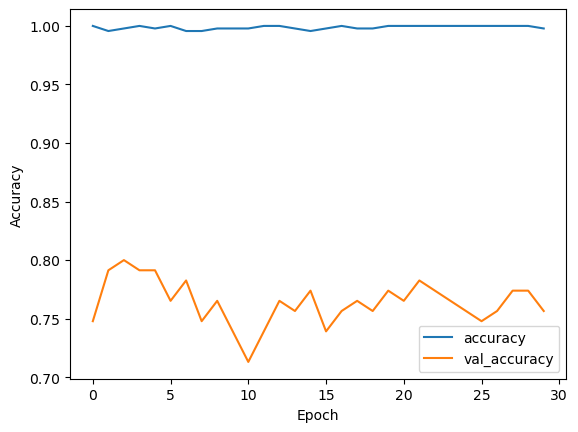

In [62]:
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

# plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Interpretation: The validation accuracy is stuck at 0.70 to 0.75. This is not a good result, since the prediction (No Appendicitis, Uncomplicated Appendicitis or Complicated Appendicitis) is quite often wrong. The result could be improved with more patients added to the data (after data cleaning there are 574 patients left). Also the question of how to handle ceratin features remains open to some extent. Should the feature "appendix diameter" be set to zero, if the appendix hasn't been found? How should other clinical features that are described rarely in the data set be treated?

## Process the image data (CNN)

#### Perpare mapping of images to targets (labels)

In [63]:
import pandas as pd
# get mapping info for the image files from app_data.xlsx
df = pd.read_excel('appendicitis_data/app_data.xlsx')
print(df['US_Number'])

0      882.0
1      883.0
2      884.0
3      886.0
4      887.0
       ...  
777    126.0
778      NaN
779    127.0
780    128.0
781    129.0
Name: US_Number, Length: 782, dtype: float64


In [73]:
# join US_Number with rpa_target so the images can be labeled
us_number_df = df[['US_Number']]
us_labeling_map = us_number_df.join(rpa_targets)
# us_labeling_map has 22 missing values, means 22 patients have no ultrasound images

us_labeling_map = us_labeling_map.dropna(subset=['US_Number']) # drop NA for int casting to work
us_labeling_map['US_Number'] = us_labeling_map['US_Number'].astype(int).astype(str) # cast as int for decimal point to disappear in strings

# remove rows with NAs in target data frame
us_labeling_map = us_labeling_map.loc[rpa_targets.notna().all(axis=1)]
# Combine the targets to keep only information about diagnosis and severity in one column
def check_dx(row): 
    if row['Diagnosis'] == 'no appendicitis':
        return 'no appendicitis'
    return row['Severity']
    
us_labeling_map['Dx_inclSeverity'] = us_labeling_map.apply(check_dx, axis=1)
# axis=1 means apply function per row
us_labeling_map = us_labeling_map.drop(columns=['Management', 'Severity', 'Diagnosis'])
us_labeling_map.head()


,US_Number,Dx_inclSeverity
0,882,uncomplicated
1,883,no appendicitis
2,884,no appendicitis
3,886,no appendicitis
4,887,uncomplicated


Export labeling data frame to csv so that images can be moved to subdirectories (needed for pipeline)

In [74]:
# Define the path where the CSV will be saved
csv_file_path = 'categories.csv'

# Export the DataFrame to a CSV file
us_labeling_map.to_csv(csv_file_path, sep='\t', index=False)

print(f"DataFrame successfully exported to {csv_file_path}")
# after creation of csv-file, run image_mover.py within the folder containing the images

DataFrame successfully exported to categories.csv


After creation of the categories.csv, move it into the folder containing the ultrasound images ("US_Pictures") and run the following scripts from within the folder:
- image_mover.py (creates subdirectories and moves the images into them)
- image_cropper.py (cutts off parts like machine info and markings)
- image_composer.py (combines images of the same patients into one)

Attempts to create compositions of the images via the tensor data have failed. Especially the process of creating a pipeline for the images made tensor manipulation more complicated. That why the compositions are created outside of the notebook and stored as new files. This uses more space and is surely less efficient than munipulating tensors, but is more straight forward for our use case. The result should be the same.

#### Load images

In [75]:
# load the directory from the .env-file (US_IMAGES_PATH=r'path/to/the/images/folder')
import os
from dotenv import load_dotenv
load_dotenv()
us_dir = os.getenv('US_IMAGES_PATH')


In [76]:
# if path from .env-file doesn't work, set absolute path here
us_dir = r'/Users/fabianburki/Desktop/BFH/Semester 6/Deep Learning/Projekt/7711412/US_Pictures/US_images_mapped_cropped'

See how many images are in the directory

In [77]:
import pathlib
data_dir = pathlib.Path(us_dir)
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

609


Load example image from directory

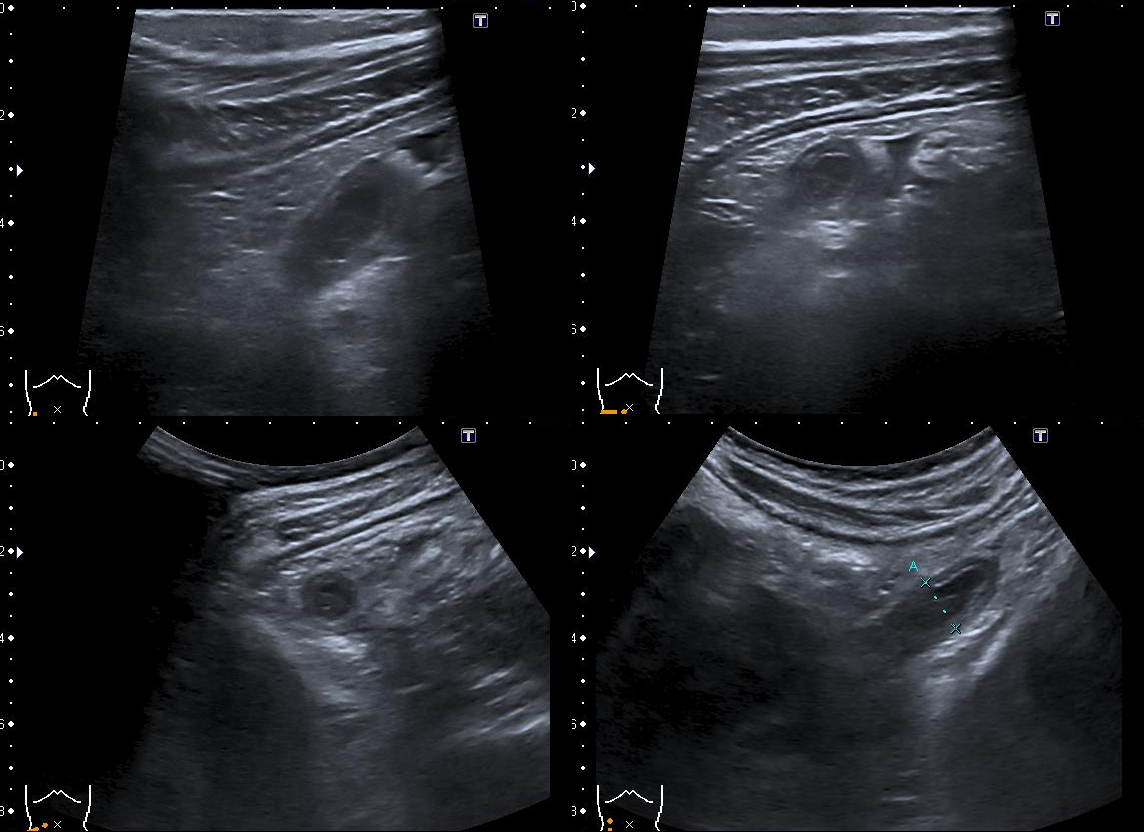

In [79]:
import PIL.Image
uncomplicated = list(data_dir.glob('uncomplicated/*'))
PIL.Image.open(str(uncomplicated[5]))

### Create pipelines for the image data

Pipeline for training data

In [81]:
batch_size = 16
img_height, img_width = 400, 400
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 609 files belonging to 3 classes.
Using 488 files for training.


Pipeline for validation data

In [85]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 609 files belonging to 3 classes.
Using 121 files for validation.


See created labels (via folder names)

In [82]:
class_names = train_ds.class_names
print(class_names)

['complicated', 'no appendicitis', 'uncomplicated']


#### Plot a few of loaded images

2024-06-20 12:02:25.759863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


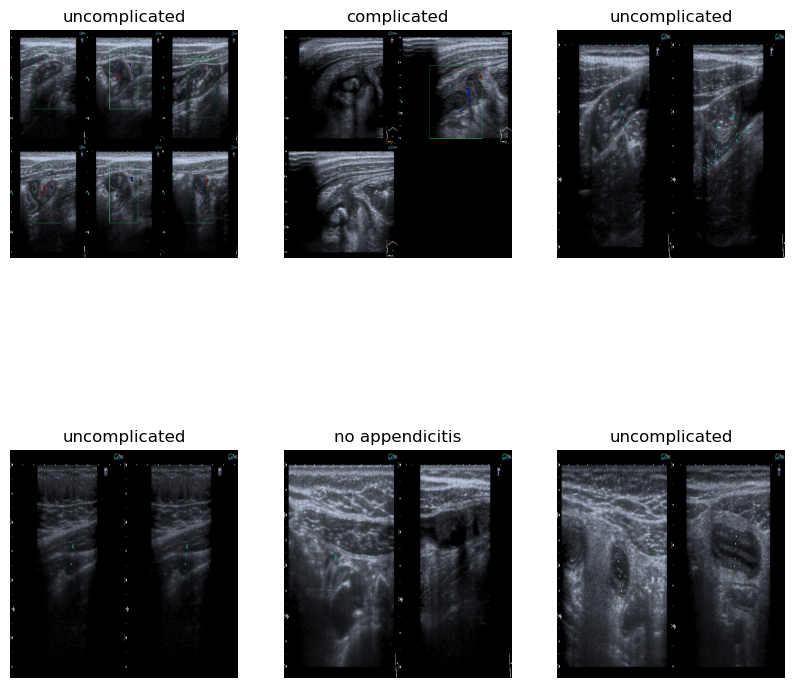

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create a model

##### RGB model with 3 channels

In [86]:
# rgb version
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 3

model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(400,400)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

/Users/fabianburki/miniconda3/envs/dl_appendicitis/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile & train the model

In [93]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Epoch 1/5


/Users/fabianburki/miniconda3/envs/dl_appendicitis/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5080 - loss: 1.3318 - val_accuracy: 0.6116 - val_loss: 0.9023
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6377 - loss: 0.8272 - val_accuracy: 0.6198 - val_loss: 0.9250
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6886 - loss: 0.6978 - val_accuracy: 0.5785 - val_loss: 1.0151
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7939 - loss: 0.5007 - val_accuracy: 0.5289 - val_loss: 1.4543
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8869 - loss: 0.2986 - val_accuracy: 0.5289 - val_loss: 1.6446


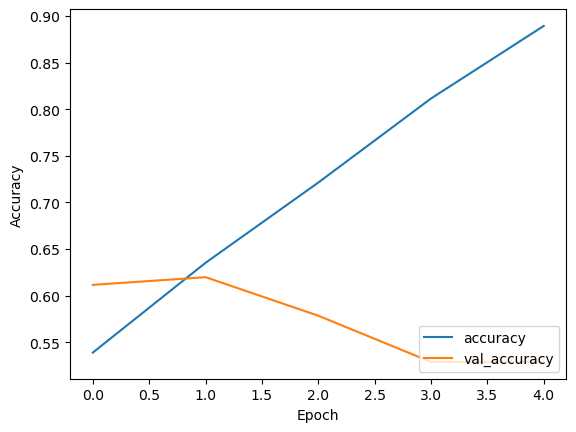

In [88]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
# plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Since ultrasound images are mostly greyscale, we wondered if a greyscale model (only one color channel) would perform better. The result was much worse, than the rgb model.

In [ ]:
# greyscale version (beware that there are images with doppler mode "_D")
"""
AUTOTUNE = tf.data.AUTOTUNE

def rgb_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

# Assuming train_ds and val_ds are already defined and loaded with RGB images
train_ds = train_ds.map(rgb_to_grayscale, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(rgb_to_grayscale, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 1, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 1, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 1, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
"""

## Combine DNN & CNN

In [90]:
import tensorflow as tf


input_shape = (400, 400, 3)  # for rgb images
input_layer = tf.keras.Input(shape=input_shape)
num_classes = 3

# create the CNN layers
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(maxpool2)
maxpool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
flatten = tf.keras.layers.Flatten()(maxpool3)

# create the DNN layers
dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
dropout = tf.keras.layers.Dropout(0.5)(dense1)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

# combined model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │   150,995,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,090,243 (576.36 MB)

 Trainable params: 151,090,243 (576.36 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Create a new model that combines the CNN and DNN
combined_model = tf.keras.Model(inputs=[model.input, input_layer], outputs=model.output)

# Compile the combined model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the combined model
history_combined = combined_model.fit([x_train, train_ds], y_train, epochs=30, batch_size=128, validation_split=0.2)

# Plot the training history
plt.plot(history_combined.history['accuracy'], label='accuracy')
plt.plot(history_combined.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

ValueError: Argument `validation_split` is only supported for tensors or NumPy arrays.Found incompatible type in the input: [<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>]

## Trying to fine-tune a pretrained model

In [1]:
# we try the multimodal model Idefics2 from https://huggingface.co/HuggingFaceM4/idefics2-8b
# Load model directly
from transformers import AutoProcessor, AutoModelForPreTraining

processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b-base")
model = AutoModelForPreTraining.from_pretrained("HuggingFaceM4/idefics2-8b-base")

/Users/fabianburki/miniconda3/envs/dl_appendicitis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-21 10:00:29.235337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.

: 

In [1]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("subh71/medical")
model = AutoModelForImageClassification.from_pretrained("subh71/medical")

/Users/fabianburki/miniconda3/envs/dl_appendicitis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-21 10:22:40.662588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/fabianburki/miniconda3/envs/dl_appendicitis/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


: 